In [2]:
import torch
import blobfile as bf
from transformer_lens import HookedTransformer
import sparse_autoencoder
from typing import List, Tuple, Dict

In [3]:
# Extract neuron activations with transformer_lens
model = HookedTransformer.from_pretrained("gpt2", center_writing_weights=False)
device = next(model.parameters()).device

/home/chiragr2/CausalProbe/venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [30]:
prompt = "This is an example of a prompt"
tokens = model.to_tokens(prompt)  # (1, n_tokens)
with torch.no_grad():
    logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=True)

layer_index = 6
location = "resid_post_mlp"

In [31]:

transformer_lens_loc = {
    "mlp_post_act": f"blocks.{layer_index}.mlp.hook_post",
    "resid_delta_attn": f"blocks.{layer_index}.hook_attn_out",
    "resid_post_attn": f"blocks.{layer_index}.hook_resid_mid",
    "resid_delta_mlp": f"blocks.{layer_index}.hook_mlp_out",
    "resid_post_mlp": f"blocks.{layer_index}.hook_resid_post",
}[location]

with bf.BlobFile(sparse_autoencoder.paths.v5_32k(location, layer_index), mode="rb") as f:
    state_dict = torch.load(f)
    autoencoder = sparse_autoencoder.Autoencoder.from_state_dict(state_dict)
    autoencoder.to(device)


In [32]:
autoencoder

Autoencoder(
  (encoder): Linear(in_features=768, out_features=32768, bias=False)
  (activation): TopK(
    (postact_fn): ReLU()
  )
  (decoder): Linear(in_features=32768, out_features=768, bias=False)
)

In [33]:
input_tensor = activation_cache[transformer_lens_loc]

input_tensor_ln = input_tensor

with torch.no_grad():
    latent_activations, info = autoencoder.encode(input_tensor_ln)
    reconstructed_activations = autoencoder.decode(latent_activations, info)

normalized_mse = (reconstructed_activations - input_tensor).pow(2).sum(dim=1) / (input_tensor).pow(2).sum(dim=1)
print(location, normalized_mse)

resid_post_mlp tensor([6.4423e-05, 3.9219e-02, 3.1569e-02, 4.6317e-02, 7.1058e-02, 4.7744e-02,
        6.2675e-02, 6.7039e-02], device='cuda:0')


In [34]:
input_tensor.shape

torch.Size([8, 768])

In [35]:
latent_activations.shape

torch.Size([8, 32768])

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_activations(latent_activations, threshold=1e-10, top_k=32):
    """
    Analyze and visualize latent activations, showing top-k activations and their addresses.
    
    Parameters:
    - latent_activations: tensor of activations
    - threshold: minimum value to consider non-zero (default: 1e-10)
    - top_k: number of top activations to display (default: 32)
    """
    # Convert to numpy if it's a tensor
    if torch.is_tensor(latent_activations):
        latent_activations = latent_activations.cpu().numpy()
    
    # Get the absolute values for finding top activations
    abs_activations = np.abs(latent_activations)
    
    # Find top k activations
    top_k_indices = np.argsort(abs_activations)[-top_k:]
    top_k_values = latent_activations[top_k_indices]
    
    # Sort by actual values for visualization
    sort_idx = np.argsort(top_k_values)
    top_k_indices = top_k_indices[sort_idx]
    top_k_values = top_k_values[sort_idx]
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Main plot
    # plt.subplot(1, 2, 1)
    plt.bar(range(len(top_k_values)), top_k_values)
    plt.title(f'Top {top_k} Latent Activations')
    plt.xlabel('Index in top-k')
    plt.ylabel('Activation Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nActivation Summary:")
    print(f"Total activations: {len(latent_activations)}")
    nonzero_count = np.sum(abs_activations > threshold)
    print(f"Non-zero activations: {nonzero_count}")
    print(f"Sparsity: {(1 - nonzero_count/len(latent_activations))*100:.2f}%")
    
    # Print top-k activations and their addresses
    print(f"\nTop {top_k} Activations:")
    print("Index    | Value")
    print("-" * 30)
    for idx, val in zip(top_k_indices, top_k_values):
        print(f"{idx:7d} | {val:0.6f}")

In [44]:
model.to_string(tokens[0])

'<|endoftext|>This is an example of a prompt'

In [45]:
tokens

tensor([[50256,  1212,   318,   281,  1672,   286,   257,  6152]],
       device='cuda:0')


Analyzing token 0 ('<|endoftext|>')


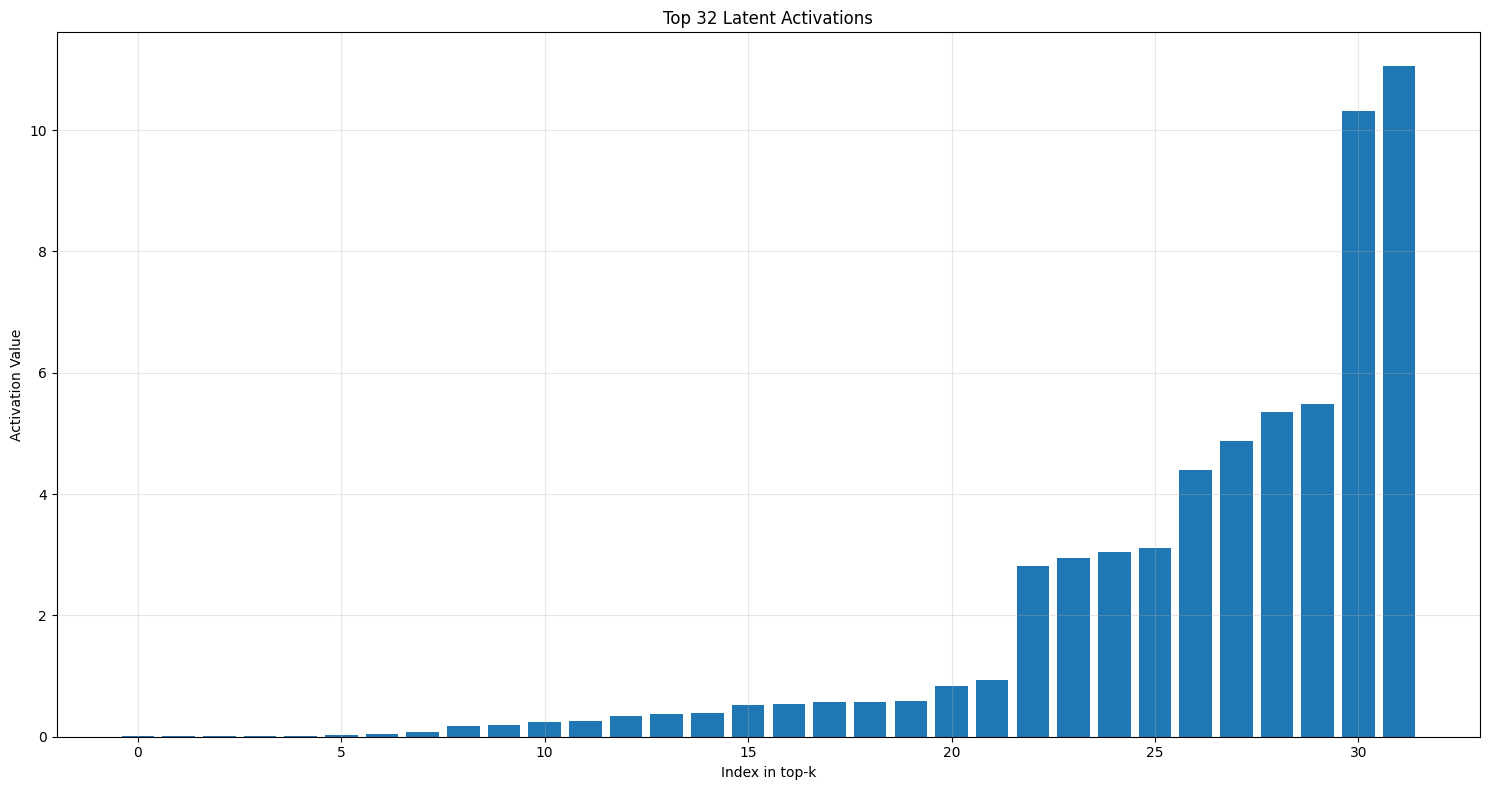


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
   1752 | 0.013628
  11417 | 0.015083
  16705 | 0.016446
  21904 | 0.016930
   3582 | 0.017746
  27723 | 0.022091
  16305 | 0.043738
  16361 | 0.073541
  23952 | 0.176542
  19610 | 0.185976
  27026 | 0.247258
  27319 | 0.264153
   9559 | 0.348129
  20767 | 0.379607
  14588 | 0.397581
  28069 | 0.514828
  17498 | 0.546902
  25403 | 0.572255
   2920 | 0.578075
  15778 | 0.594421
  18271 | 0.842375
   7614 | 0.938474
   9582 | 2.813592
   2147 | 2.946006
  17886 | 3.053117
  11591 | 3.114549
  27167 | 4.389937
  20387 | 4.880081
  20932 | 5.351735
  31931 | 5.484746
  32004 | 10.313267
  31538 | 11.060106

Analyzing token 1 ('This')


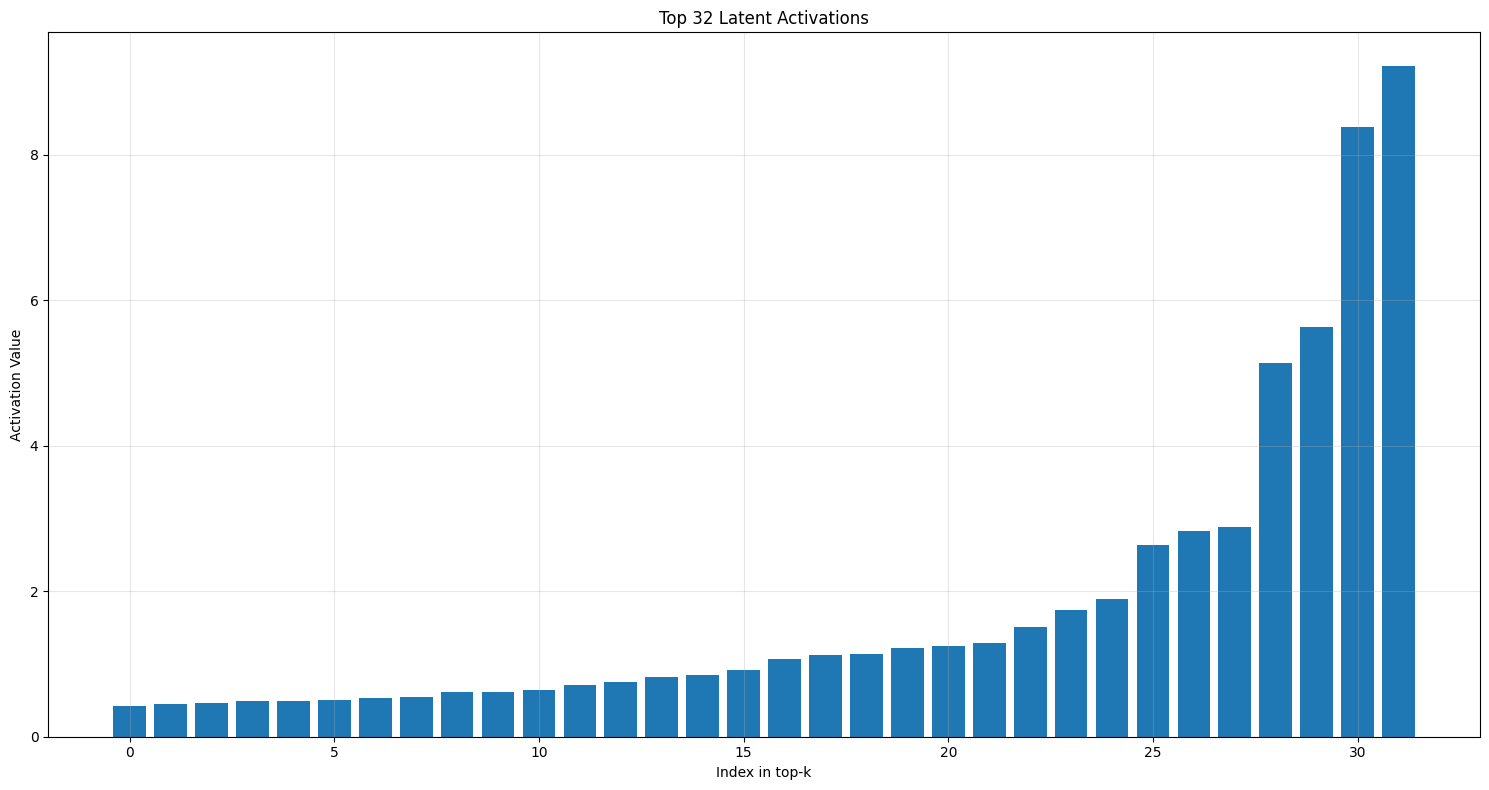


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
  16927 | 0.427325
  10388 | 0.453571
   6291 | 0.470020
  18525 | 0.485334
  24370 | 0.494435
   6343 | 0.509405
   7450 | 0.533808
  22758 | 0.550975
   3953 | 0.617247
  28690 | 0.620251
  32131 | 0.640732
  17355 | 0.705198
  24733 | 0.746425
  31302 | 0.824497
  20493 | 0.853531
  31767 | 0.923369
  31538 | 1.071009
   7642 | 1.120046
   6570 | 1.142540
   9772 | 1.223122
  13804 | 1.241084
   4416 | 1.290090
  21937 | 1.511624
   1835 | 1.740332
  11301 | 1.898728
   9278 | 2.631558
  20317 | 2.823889
  32729 | 2.885350
  26575 | 5.142242
  23872 | 5.637442
  20632 | 8.376424
  10637 | 9.220443

Analyzing token 2 (' is')


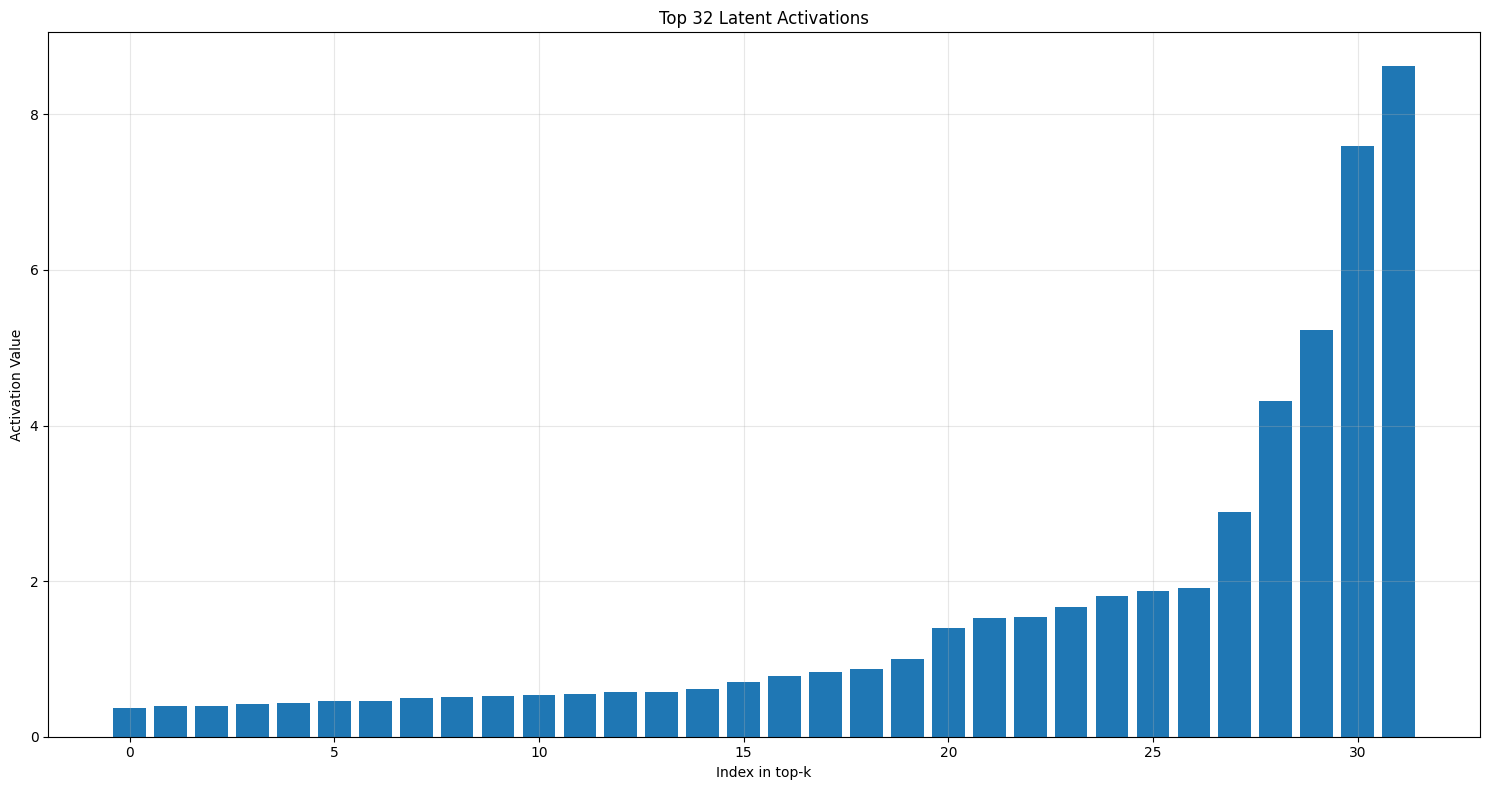


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
  22633 | 0.374942
   7450 | 0.392549
  15769 | 0.396561
   7015 | 0.425071
  20527 | 0.431703
  16919 | 0.459114
  32131 | 0.465067
   1494 | 0.495277
  28690 | 0.510481
   1835 | 0.524252
   1391 | 0.539374
   5758 | 0.554431
  11301 | 0.570752
  28760 | 0.576299
  25957 | 0.611054
  14943 | 0.697609
   6291 | 0.777014
  21499 | 0.831440
   4416 | 0.866838
   3953 | 0.998305
   9772 | 1.400331
   9223 | 1.529528
  17450 | 1.544677
  22472 | 1.673874
  28935 | 1.810695
   3845 | 1.874380
  16936 | 1.916811
  15474 | 2.894994
    927 | 4.318521
  23872 | 5.228749
   5360 | 7.591307
  20039 | 8.623543

Analyzing token 3 (' an')


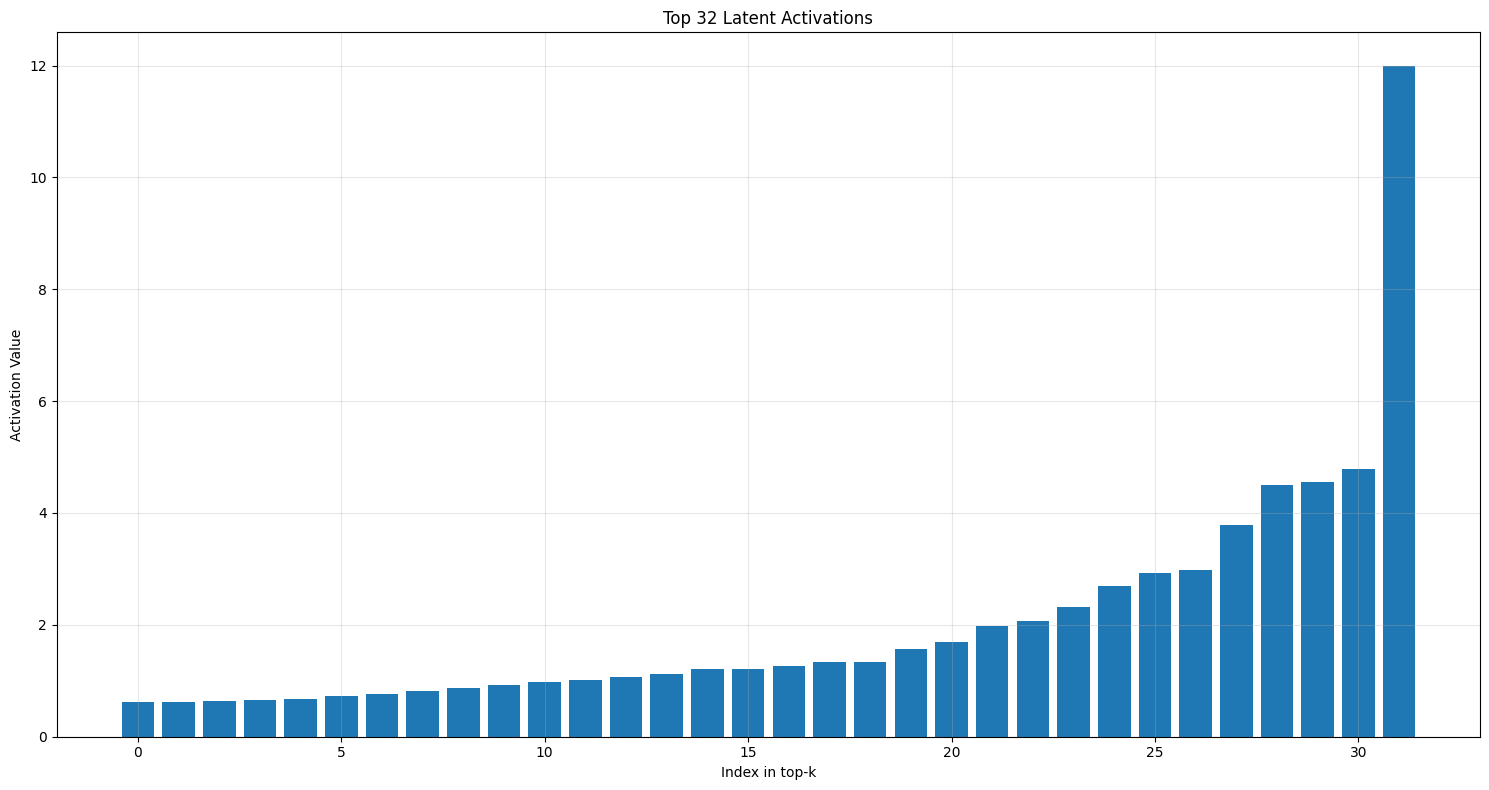


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
    318 | 0.615138
  20527 | 0.627176
  21499 | 0.634932
   2406 | 0.663023
   4416 | 0.669755
  22472 | 0.724403
   7450 | 0.763599
  15210 | 0.826275
  22659 | 0.866626
  28690 | 0.924727
   3953 | 0.972595
  26445 | 1.015298
  31465 | 1.059933
  30691 | 1.116484
  28645 | 1.213144
   6291 | 1.217970
   4230 | 1.265816
   9772 | 1.327496
  24733 | 1.340288
  32131 | 1.574742
  28693 | 1.689815
  28935 | 1.982180
  17450 | 2.067504
   1835 | 2.314265
  16811 | 2.696340
  11260 | 2.919440
    927 | 2.986744
  15474 | 3.785281
  17590 | 4.491484
  26012 | 4.561866
  23872 | 4.784310
   8468 | 11.993553

Analyzing token 4 (' example')


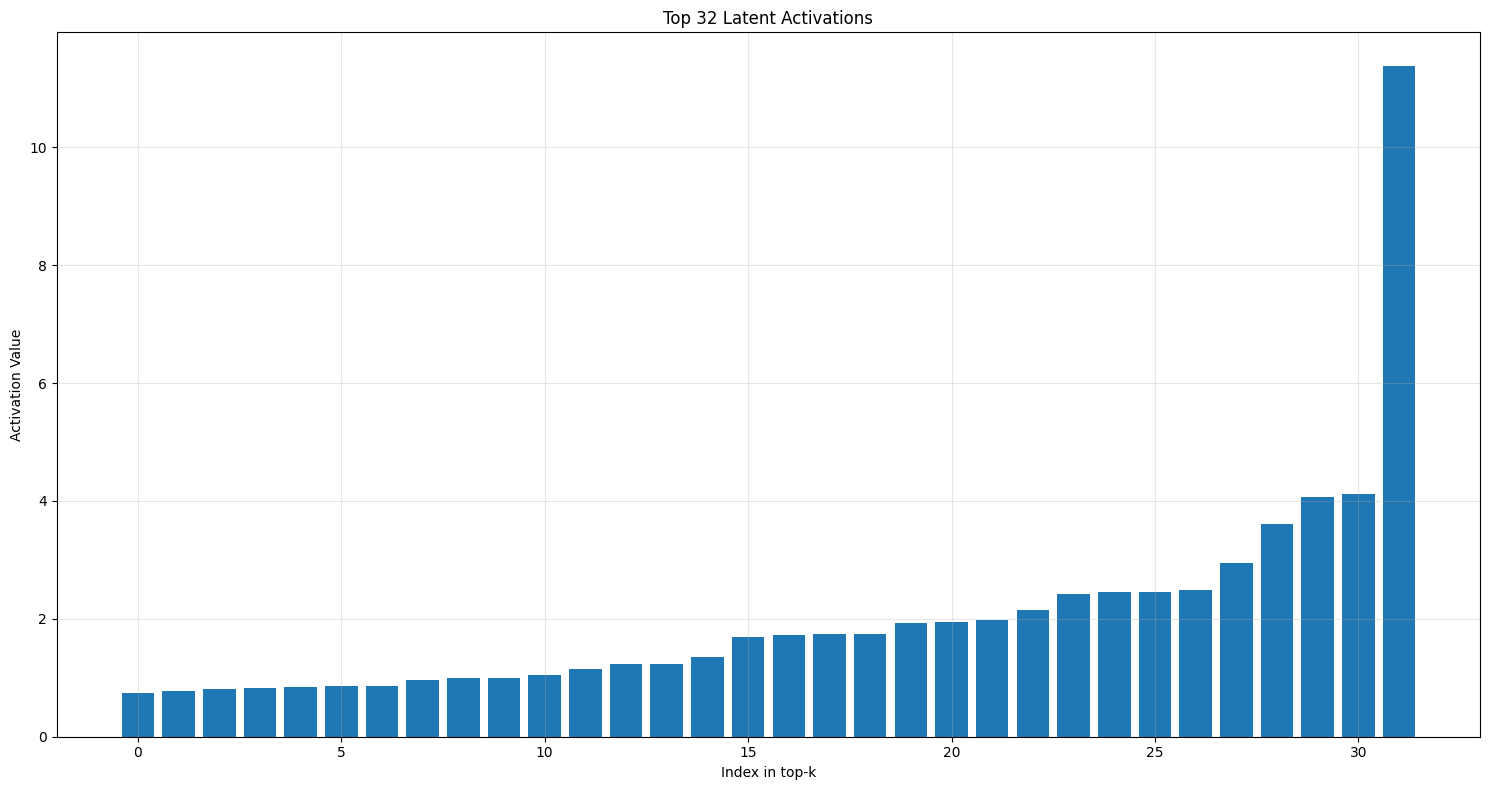


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
  27290 | 0.747233
   8328 | 0.774279
  19228 | 0.808214
  26012 | 0.819896
  10832 | 0.848801
  22659 | 0.859934
   4230 | 0.862979
  26629 | 0.957503
  23258 | 0.992070
   9772 | 0.997004
  15210 | 1.049429
  13488 | 1.152780
  15474 | 1.237211
  13359 | 1.241308
   4625 | 1.350751
  28645 | 1.688261
   6143 | 1.727128
  29795 | 1.736297
  11929 | 1.745595
  28690 | 1.931874
   8052 | 1.944896
  23144 | 1.972134
  32131 | 2.145126
  26445 | 2.425114
  28935 | 2.448820
    927 | 2.457119
   1925 | 2.488134
  17450 | 2.950325
  18804 | 3.608626
  23872 | 4.073655
  26023 | 4.113880
  23748 | 11.379744

Analyzing token 5 (' of')


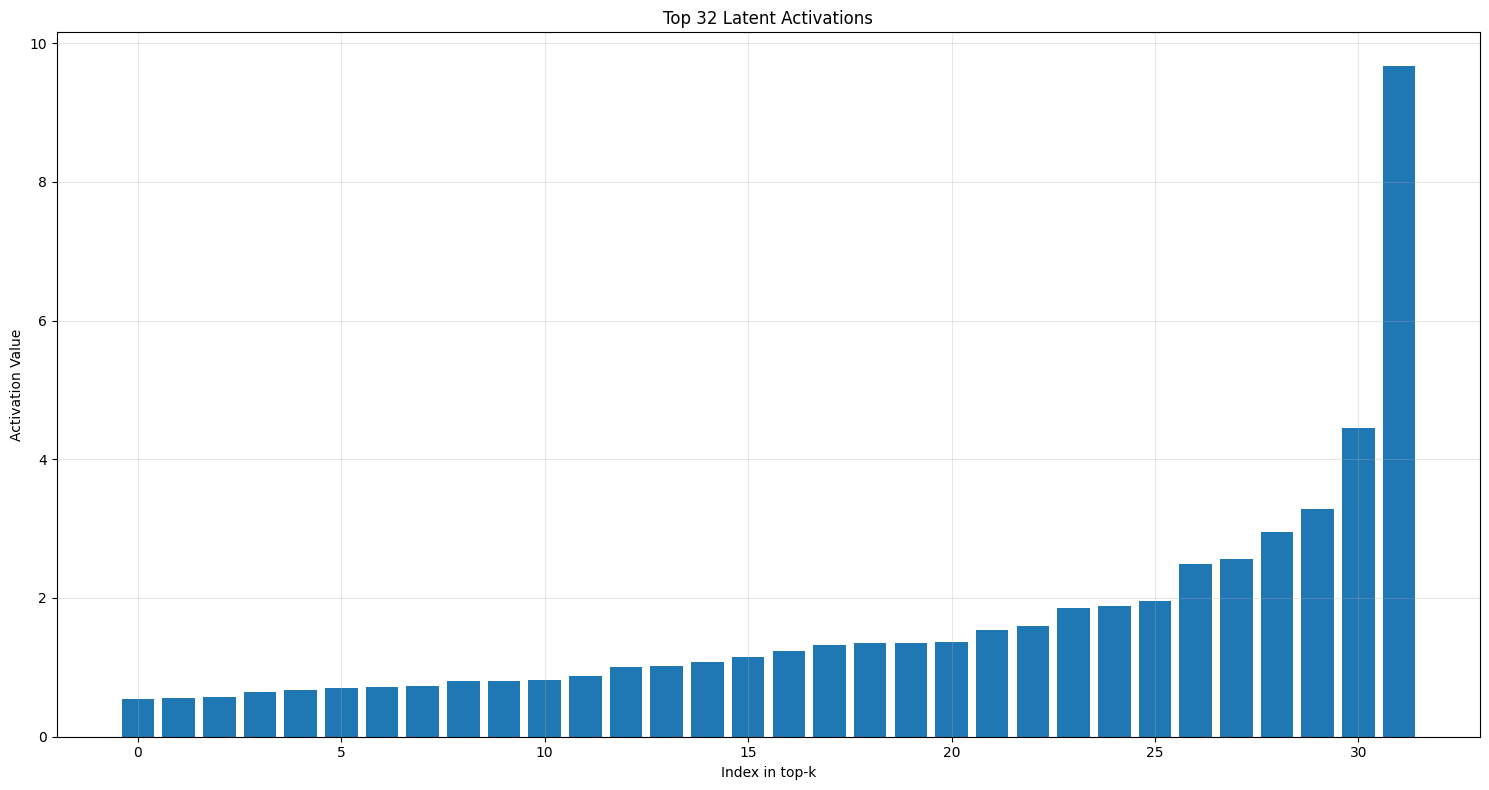


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
   7037 | 0.548743
  19950 | 0.558420
  29795 | 0.574639
  26830 | 0.639844
  32527 | 0.680507
  14275 | 0.705895
  28645 | 0.710633
  29931 | 0.736894
   1056 | 0.800932
  19228 | 0.810004
   3292 | 0.814179
   5874 | 0.878365
   9772 | 1.004422
  13241 | 1.019953
   1835 | 1.070561
  26445 | 1.155797
  17450 | 1.232117
  28690 | 1.318542
  24732 | 1.345461
   8328 | 1.354754
  32131 | 1.371925
     63 | 1.540961
    927 | 1.594384
  15363 | 1.853166
   9943 | 1.883739
  16584 | 1.959437
  20786 | 2.492904
  28935 | 2.558893
   8393 | 2.949831
   8666 | 3.275998
  23872 | 4.450834
   1925 | 9.670996

Analyzing token 6 (' a')


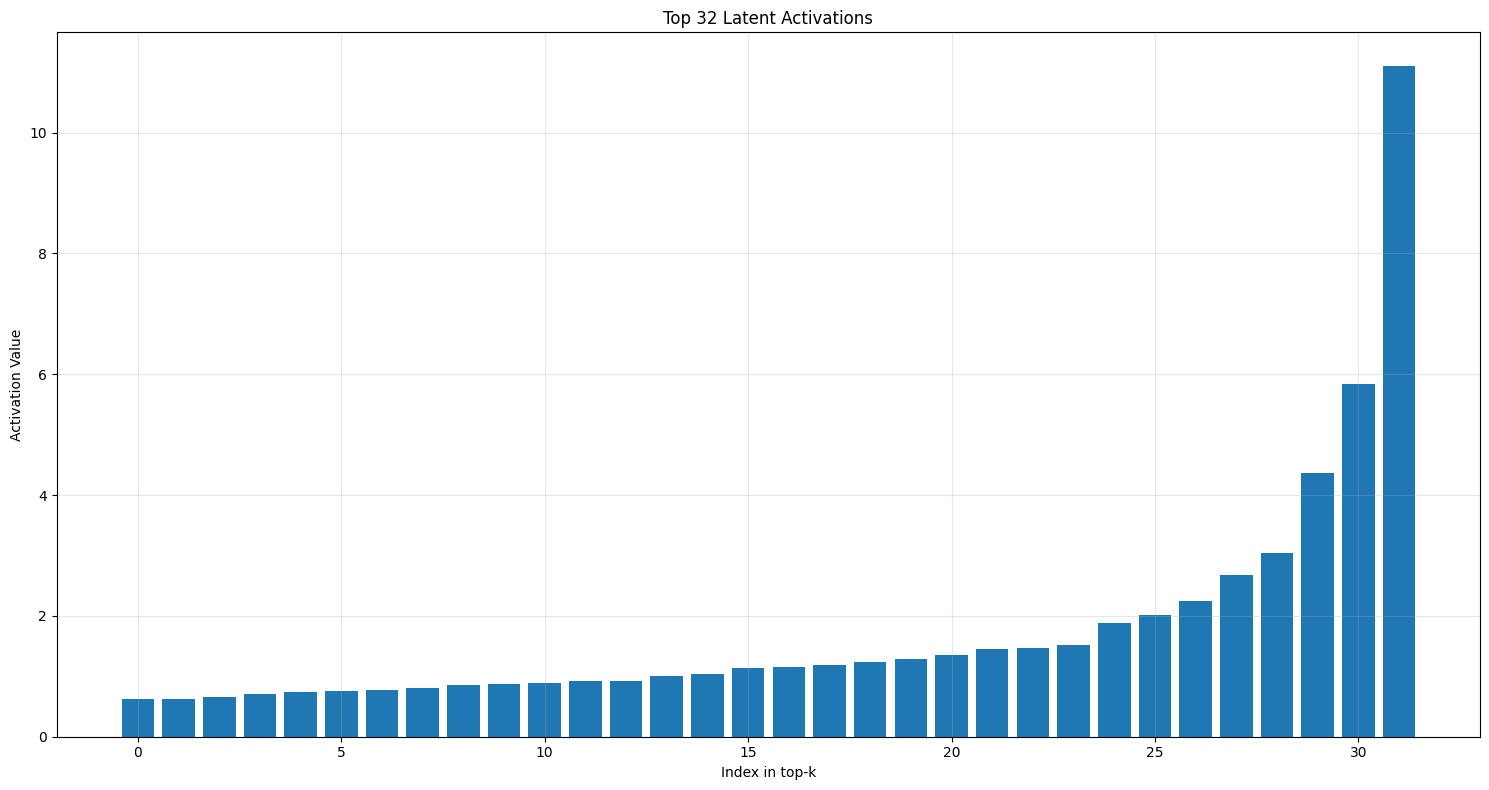


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
  22689 | 0.620325
  16811 | 0.625220
  23273 | 0.656818
   1056 | 0.712040
  28645 | 0.739650
  32131 | 0.754309
  10763 | 0.765751
  31677 | 0.812241
  12612 | 0.860745
  26012 | 0.878315
  21975 | 0.892015
  16584 | 0.919085
   4005 | 0.926389
  31077 | 0.999768
  28690 | 1.032242
  17450 | 1.131526
    871 | 1.148869
   9772 | 1.189371
   5874 | 1.234367
   4230 | 1.288826
   2431 | 1.348122
  11312 | 1.457410
   8328 | 1.464886
  24732 | 1.513409
  26445 | 1.878846
   1835 | 2.012449
  28935 | 2.249010
   2387 | 2.680819
   8393 | 3.047706
  23872 | 4.362879
   1925 | 5.833470
   7259 | 11.104450

Analyzing token 7 (' prompt')


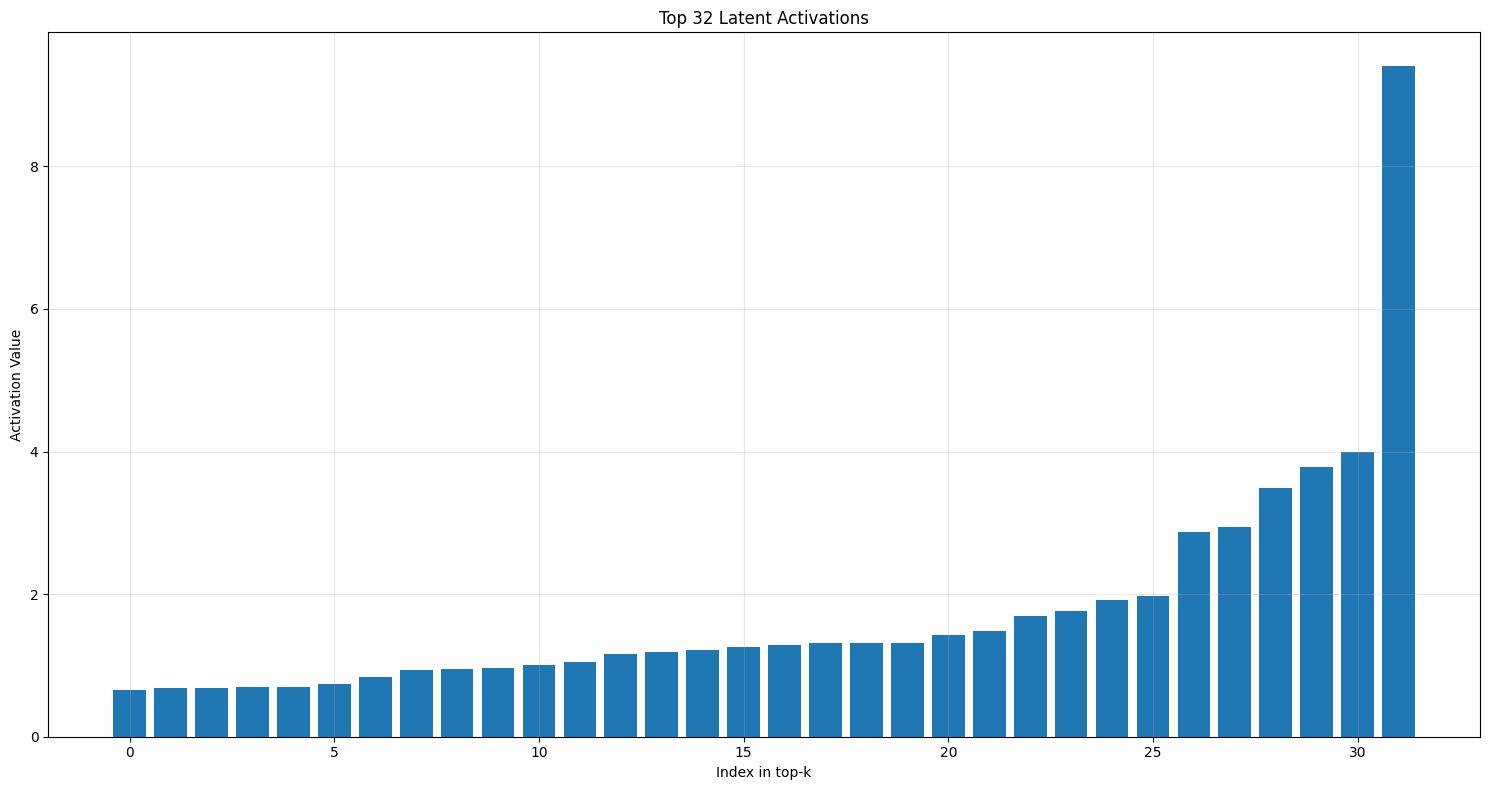


Activation Summary:
Total activations: 32768
Non-zero activations: 32
Sparsity: 99.90%

Top 32 Activations:
Index    | Value
------------------------------
  17659 | 0.661712
   9772 | 0.683005
  28699 | 0.689246
  20984 | 0.690664
  27618 | 0.694845
  10495 | 0.738010
   4923 | 0.836833
   9050 | 0.933855
    309 | 0.949503
  28690 | 0.965755
  18165 | 1.004989
  16364 | 1.052907
   2900 | 1.163365
  31199 | 1.191432
  29060 | 1.212885
  14253 | 1.261717
   8393 | 1.279730
  11140 | 1.307721
  16610 | 1.313764
   1835 | 1.314838
   3559 | 1.427044
  28935 | 1.485373
  31538 | 1.698503
  19884 | 1.767902
   2635 | 1.913369
  26754 | 1.975365
  18018 | 2.864589
  27134 | 2.945545
  26621 | 3.491985
  26023 | 3.787999
  23872 | 3.993288
  18547 | 9.409814


In [46]:
for token_idx in range(latent_activations.shape[0]):
    print(f"\nAnalyzing token {token_idx} ('{model.to_string(tokens[0][token_idx])}')")
    analyze_activations(latent_activations[token_idx])

In [24]:
latent_activations[1]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')